# Import packages and path

In [1]:
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load data and Model Architecture

In [2]:
import tensorflow as tf
from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_cifar10
import numpy as np

from art.utils import load_dataset
import numpy as np
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, models, losses

model = models.Sequential()

# Source here: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
model.add(layers.Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10))

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

loss_object = losses.CategoricalCrossentropy(from_logits=True)
def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))


2022-09-20 10:52:32.494645: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-20 10:52:38.695758: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-20 10:52:38.697058: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-20 10:52:38.717403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-20 10:52:38.718072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-

In [3]:
# model = tf.keras.models.load_model('save_model.h5')

# Train Substitute Model

In [4]:
from art.estimators.classification import TensorFlowV2Classifier

classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=loss_object,
    train_step=train_step,
    nb_classes=10,
    input_shape=(32, 32, 3),
    clip_values=(min_, max_),
    preprocessing=(mean,std)
)

In [5]:
print(np.min(x_test),np.max(x_test))
print(np.min(x_train),np.max(x_train))

0.0 1.0
0.0 1.0


In [6]:
classifier.fit(x_train, y_train, nb_epochs=40, batch_size=128)
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

2022-09-20 10:52:47.680886: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-09-20 10:52:49.178706: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-09-20 10:52:49.364297: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-20 10:52:51.527049: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Accuracy on benign test examples: 81.55%


In [7]:
classifier.model.save("new.h5")

In [8]:
from PIL import Image
from numpy import asarray
from skimage.transform import resize

patch_size = 8
img = Image.open('trigger_10.png')
numpydata = asarray(img)
patch = resize(numpydata, (patch_size,patch_size,3))
x_train_orig = np.copy(x_train)

In [9]:
class_source = 0
class_target = 1
K = 1000

# Select Triggers for attack

In [10]:
from art.utils import to_categorical

def select_trigger_train(x_train,y_train,K,class_source,class_target):
    x_train_ = np.copy(x_train)
    index_source = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
    index_target = np.where(y_train.argmax(axis=1)==class_target)[0]
    x_trigger = x_train_[index_source]
    y_trigger  = to_categorical([class_target], nb_classes=10)
    y_trigger = np.tile(y_trigger,(len(index_source),1))
    return x_trigger,y_trigger,index_target

In [11]:
x_trigger,y_trigger,index_target = select_trigger_train(x_train,y_train,K,class_source,class_target)

# Attack and Generate Poison Images

In [12]:
from art.attacks.poisoning.sleeper_agent_attack import SleeperAgentAttack
attack = SleeperAgentAttack(classifier,
                                percent_poison=0.2,
                                max_trials=1,
                                max_epochs=500,
                                learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
                                clip_values=(min_,max_),
                                epsilon=16/255,
                                batch_size=500,
                                verbose=1,
                                indices_target=index_target,
                                patching_strategy="random",
                                selection_strategy="max-norm",
                                patch=patch,
                                retraining_factor = 4,
                                model_retrain = True,
                                model_retraining_epoch = 40,
                                class_source = class_source,
                                class_target = class_target
                           )
x_poison, y_poison = attack.poison(x_trigger,y_trigger,x_train,y_train,x_test,y_test) 
indices_poison = attack.get_poison_indices()

  0%|          | 0/1 [00:00<?, ?it/s]

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
  <tf.Variable 'conv2d/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
  <tf.Variable 'conv2d_1/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
  <tf.Variable 'conv2d_2/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
  <tf.Variable 'conv2d_3/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense/kernel:0' shape=(2304, 512) dtype=float32>
  <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32>
  <tf.Variable 'dense_1/kernel:0' shape=(512, 10) dtype=float32>
  <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this la

0epoch [00:00, ?epoch/s]

2022-09-20 10:58:56.405259: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-20 10:58:56.405920: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

In [13]:
indices_poison.sort()

In [14]:
indices_poison

array([  10,   33,   42,   44,   52,   54,   55,   60,   64,   65,   69,
         74,   76,   78,   86,   94,   95,   98,   99,  101,  102,  107,
        109,  116,  126,  127,  131,  133,  134,  137,  138,  139,  144,
        145,  155,  163,  164,  168,  177,  183,  191,  192,  195,  196,
        208,  212,  222,  225,  228,  237,  249,  260,  261,  262,  263,
        264,  269,  275,  276,  278,  283,  285,  286,  294,  297,  298,
        308,  311,  315,  316,  318,  321,  322,  325,  330,  341,  354,
        356,  360,  373,  374,  378,  381,  384,  385,  387,  389,  392,
        395,  404,  414,  415,  417,  427,  433,  437,  440,  442,  446,
        461,  468,  469,  475,  477,  478,  489,  491,  494,  495,  496,
        503,  504,  506,  514,  515,  516,  523,  526,  532,  541,  545,
        555,  557,  568,  583,  584,  592,  594,  595,  597,  602,  605,
        612,  614,  615,  618,  619,  623,  634,  636,  642,  643,  646,
        655,  666,  680,  682,  684,  692,  693,  6

In [15]:
print(np.min(x_poison),np.max(x_poison))

0.0 1.0


# Retrain New Model from Scratch

In [16]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, models, losses

model_poisoned = models.Sequential()

# Source here: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
model_poisoned.add(layers.Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=x_train.shape[1:]))
model_poisoned.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_poisoned.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_poisoned.add(layers.Dropout(0.25))

model_poisoned.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model_poisoned.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_poisoned.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_poisoned.add(layers.Dropout(0.25))

model_poisoned.add(layers.Flatten())
model_poisoned.add(layers.Dense(512, activation='relu'))
model_poisoned.add(layers.Dropout(0.5))
model_poisoned.add(layers.Dense(10))

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model_poisoned.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

loss_object = losses.CategoricalCrossentropy(from_logits=True)
def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))



In [17]:
from art.estimators.classification import TensorFlowV2Classifier

classifier_poisoned = TensorFlowV2Classifier(
    model=model_poisoned,
    loss_object=loss_object,
    train_step=train_step,
    nb_classes=10,
    input_shape=(32, 32, 3),
    clip_values=(min_, max_),
    preprocessing=(mean,std)
)

In [18]:
classifier_poisoned.fit(x_poison, y_poison, nb_epochs=40, batch_size=128)

In [19]:
predictions = classifier_poisoned.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 81.16%


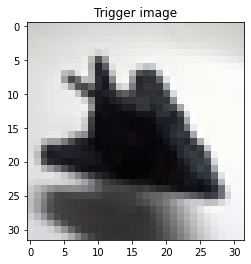

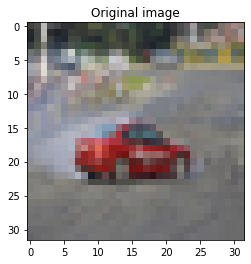

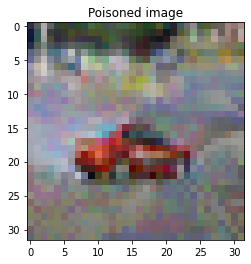

In [24]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0])
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_target[indices_poison][0]])
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_target[indices_poison][0]])
plt.title('Poisoned image')
plt.show()

In [21]:
def add_trigger_patch(x_set,patch_type="fixed"):
    img = Image.open('trigger_10.png')
    numpydata = asarray(img)
    patch = resize(numpydata, (8,8,3))
    if patch_type == "fixed":
        x_set[:,-patch_size:,-patch_size:,:] = patch
    else:
        for x in x_set:
            x_cord = random.randrange(0,x.shape[0] - patch.shape[0] + 1)
            y_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            x[x_cord:x_cord+patch_size,y_cord:y_cord+patch_size,:]=patch

    return x_set

# Calculate Success Rates

0.0 1.0
0.0 1.0
5000
Train Success Rate 0.2186


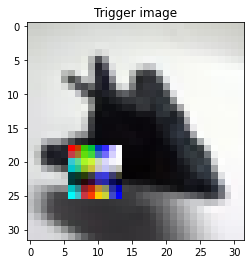

In [22]:
import random
index_source_train = np.where(y_train.argmax(axis=1)==class_source)[0]
x_train_trigger = x_train[index_source_train]
print(np.min(x_train_trigger),np.max(x_train_trigger))
x_train_trigger = add_trigger_patch(x_train_trigger,"random")
print(np.min(x_train_trigger),np.max(x_train_trigger))
result_poisoned_train = classifier_poisoned.predict(x_train_trigger)
print(len(result_poisoned_train))

success_train = (np.argmax(result_poisoned_train,axis=1)==class_target).sum()/result_poisoned_train.shape[0]
print("Train Success Rate",success_train)
plt.imshow(x_train_trigger[0])
plt.title('Trigger image')
plt.show()

1.0
1000
Test Success Rate: 0.202


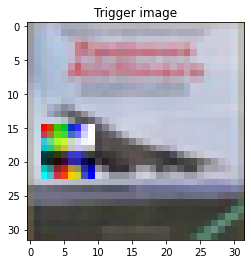

In [23]:
import random
index_source_test = np.where(y_test.argmax(axis=1)==class_source)[0]
x_test_trigger = x_test[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"random")
print(np.max(x_test_trigger))
result_poisoned_test = classifier_poisoned.predict(x_test_trigger)
print(len(result_poisoned_test))

success_test = (np.argmax(result_poisoned_test,axis=1)==class_target).sum()/result_poisoned_test.shape[0]
print("Test Success Rate:",success_test)

plt.imshow(x_test_trigger[0])
plt.title('Trigger image')
plt.show()